# 2. Common DataStore functions
Examples of how to do some of the more commonly used functions:

1. mean, min, max, std
2. Selecting
3. Selecting by index
4. Downsample (time dimension)
5. Upsample / Interpolation (length and time dimension)

In [1]:
import os

from dtscalibration import read_silixa_files

First we load the raw measurements into a `DataStore` object, as we learned from the previous notebook.

In [2]:
filepath = os.path.join("..", "..", "tests", "data", "single_ended")

ds = read_silixa_files(directory=filepath, timezone_netcdf="UTC", file_ext="*.xml")

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended
Reading the data from disk


## 0 Access the data
The implemented read routines try to read as much data from the raw DTS files as possible. Usually they would have coordinates (time and space) and Stokes and anti Stokes measurements. We can access the data by key. It is presented as a DataArray. More examples are found at http://xarray.pydata.org/en/stable/indexing.html

In [3]:
ds["st"]  # is the data stored, presented as a DataArray

<xarray.DataArray 'st' (x: 1461, time: 3)>
array([[-8.05791e-01,  4.28741e-01, -5.13021e-01],
       [-4.58870e-01, -1.24484e-01,  9.68469e-03],
       [ 4.89174e-01, -9.57734e-02,  5.62837e-02],
       ...,
       [ 4.68457e+01,  4.72201e+01,  4.79139e+01],
       [ 3.76634e+01,  3.74649e+01,  3.83160e+01],
       [ 2.79879e+01,  2.78331e+01,  2.88055e+01]])
Coordinates:
  * x                  (x) float64 -80.74 -80.62 -80.49 ... 104.6 104.7 104.8
    filename           (time) <U31 'channel 2_20180504132202074.xml' ... 'cha...
    filename_tstamp    (time) int64 20180504132202074 ... 20180504132303723
    timestart          (time) datetime64[ns] 2018-05-04T12:22:02.710000 ... 2...
    timeend            (time) datetime64[ns] 2018-05-04T12:22:32.710000 ... 2...
  * time               (time) datetime64[ns] 2018-05-04T12:22:17.710000 ... 2...
    acquisitiontimeFW  (time) timedelta64[ns] 00:00:30 00:00:30 00:00:30
Attributes:
    name:         st
    description:  Stokes intensity
    units:        -

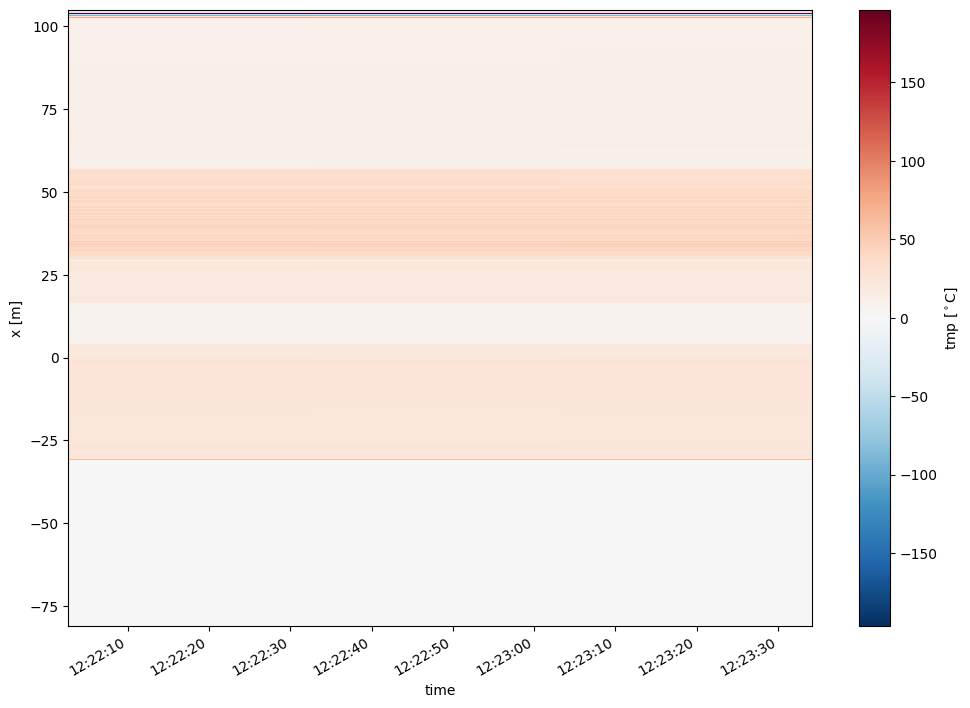

In [4]:
ds["tmp"].plot(figsize=(12, 8));

## 1 mean, min, max
The first argument is the dimension. The function is taken along that dimension. `dim` can be any dimension (e.g., `time`, `x`). The returned `DataStore` does not contain that dimension anymore.

Normally, you would like to keep the attributes (the informative texts from the loaded files), so set `keep_attrs` to `True`. They don't take any space compared to your Stokes data, so keep them.

Note that also the sections are stored as attribute. If you delete the attributes, you would have to redefine the sections.

In [5]:
ds_min = ds.mean(
    dim="time", keep_attrs=True
)  # take the minimum of all data variables (e.g., Stokes, Temperature) along the time dimension

In [6]:
ds_max = ds.max(
    dim="x", keep_attrs=True
)  # Take the maximum of all data variables (e.g., Stokes, Temperature) along the x dimension

In [7]:
ds_std = ds.std(
    dim="time", keep_attrs=True
)  # Calculate the standard deviation along the time dimension

## 2 Selecting
What if you would like to get the maximum temperature between $x >= 20$ m and $x < 35$ m over time? We first have to select a section along the cable.

In [8]:
section = slice(20.0, 35.0)
section_of_interest = ds.sel(x=section)

In [9]:
section_of_interest_max = section_of_interest.max(dim="x")

What if you would like to have the measurement at approximately $x=20$ m?

In [10]:
point_of_interest = ds.sel(x=20.0, method="nearest")

## 3 Selecting by index
What if you would like to see what the values on the first timestep are? We can use isel (index select) 

In [11]:
section_of_interest = ds.isel(time=slice(0, 2))  # The first two time steps

In [12]:
section_of_interest = ds.isel(x=0)

## 4 Downsample (time dimension)
We currently have measurements at 3 time steps, with 30.001 seconds inbetween. For our next exercise we would like to down sample the measurements to 2 time steps with 47 seconds inbetween. The calculated variances are not valid anymore. We use the function `resample` from xarray.

In [28]:
# We use the logic from xarray to resample. However, it returns an xarray dataset type
import xarray as xr
ds_xarray = xr.Dataset(ds).resample(time="47S").mean()

# Therefore we convert it back to the dtscalibration Datastore type.
from dtscalibration import DataStore
ds_resampled2 = DataStore(ds_xarray)

Note that the resample function from dtscalibration has been removed in v2.0.1. The above example works versions from before 2.0.1 as well. Starting with version 2.0.1 the `xr.Dataset(ds).resample()` may become `ds.resample()`.

## 5 Upsample / Interpolation (length and time dimension)
So we have measurements every 0.12 cm starting at $x=0$ m. What if we would like to change our coordinate system to have a value every 12 cm starting at $x=0.05$ m. We use (linear) interpolation, extrapolation is not supported. The calculated variances are not valid anymore.

In [ ]:
x_old = ds.x.data
x_new = x_old[:-1] + 0.05  # no extrapolation
ds_xinterped = ds.interp(coords={"x": x_new})

We can do the same in the time dimension

In [ ]:
import numpy as np

time_old = ds.time.data
time_new = time_old + np.timedelta64(10, "s")
ds_tinterped = ds.interp(coords={"time": time_new})